In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dnn_app_utils_v2 import load_data,sigmoid,relu,sigmoid_backward,relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


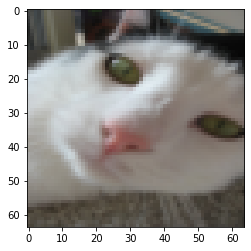

In [5]:
# Example of a picture
index = 14
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [8]:
layers_dims = [12288,10,1]

In [9]:
def initialize_deep_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1)) 
        
        assert(parameters["W"+str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters["b"+str(l)].shape == (layer_dims[l],1))
        
    return parameters

In [10]:
#check parameter initialization function
parameters = initialize_deep_parameters([5,4,3,2,1])
for x in range(1,len(layers_dims)):
    print("W" + str(x) + " : ",parameters["W" + str(x)])
    print("b" + str(x) + " : ", parameters["b" + str(x)])

W1 :  [[ 0.01624345 -0.00611756 -0.00528172 -0.01072969  0.00865408]
 [-0.02301539  0.01744812 -0.00761207  0.00319039 -0.0024937 ]
 [ 0.01462108 -0.02060141 -0.00322417 -0.00384054  0.01133769]
 [-0.01099891 -0.00172428 -0.00877858  0.00042214  0.00582815]]
b1 :  [[0.]
 [0.]
 [0.]
 [0.]]
W2 :  [[-0.01100619  0.01144724  0.00901591  0.00502494]
 [ 0.00900856 -0.00683728 -0.0012289  -0.00935769]
 [-0.00267888  0.00530355 -0.00691661 -0.00396754]]
b2 :  [[0.]
 [0.]
 [0.]]


In [11]:
def compute_cost(AL,Y,parameters,lambd):
    
    m = Y.shape[1]
    cost = (-1/m)*(np.dot(Y,np.log(AL).T) + np.dot((1-Y),np.log(1 - AL).T))
    L2_regularization = 0
    L = len(parameters)//2
    for x in range(1,L+1):
        L2_regularization = L2_regularization + np.sum(np.square(parameters["W"+str(x)]))
        
    L2_regularization = (1/m)*(lambd/2)*L2_regularization
    cost = cost + L2_regularization
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

In [12]:
def linear_forward(A,W,b):
    
    Z = np.dot(W,A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [13]:
def linear_activation_forward(A_prev,W,b,activation):
    
    if(activation == "relu"):
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    elif(activation == "sigmoid"):
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache,activation_cache)
    
    return A,cache
        

In [14]:
def L_model_forward(X,parameters):
        
    caches = []  #Each entry contains linear and activation caches
                 #of each layer.
    L = len(parameters) // 2  
    A = X
    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev,
                                            parameters["W"+str(l)],
                                            parameters["b"+str(l)],
                                            "relu")
        caches.append(cache)
        
    AL,cache = linear_activation_forward(A,
                                         parameters["W"+str(L)],
                                         parameters["b"+str(L)],
                                         "sigmoid")
    caches.append(cache)
    
    
    assert(AL.shape == (1,X.shape[1]))

    return AL,caches
        

In [15]:
def linear_backward(dZ,cache):
    
    A_prev,W,b = cache
    m = A_prev.shape[1]
    
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    
    return dA_prev,dW,db

In [16]:
def linear_activation_backward(dA,cache,activation):
    
    linear_cache,activation_cache = cache
    
    if(activation == "sigmoid"):
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
    elif(activation == "relu"):
        dZ = relu_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
        
    return dA_prev,dW,db

In [17]:
def L_model_backward(AL,Y,caches,parameters,lambd):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = linear_activation_backward(dAL,
                                                                                              current_cache
                                                                                              ,"sigmoid")
    
    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        dA_prev_temp,dW_temp,db_temp = linear_activation_backward(grads["dA"+str(l+1)],
                                                                  current_cache,
                                                                  activation = "relu")
        
        grads["dA"+str(l)] = dA_prev_temp 
        grads["dW"+str(l+1)] = dW_temp + lambd*parameters["W"+str(l+1)]
        grads["db"+str(l+1)] = db_temp
        
    return grads


In [18]:
def update_parameters(parameters,grads,learning_rate):
    
    L = len(parameters) // 2
    for l in range(1,L+1):
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate*grads["dW"+str(l)]
        parameters["b"+str(l)] = parameters["b" +str(l)] - learning_rate*grads["db"+str(l)]
        
    return parameters


In [19]:
parameters = initialize_deep_parameters(layers_dims)
for l in range(1,len(layers_dims)):
    print(parameters["W"+str(l)].shape)
    print(parameters["b"+str(l)].shape)

(10, 12288)
(10, 1)
(1, 10)
(1, 1)


In [20]:
def L_layer_model(X,Y,layer_dims,learning_rate = 0.0075,num_iterations = 3000,lambd = 0.6):
    
    costs = []
    parameters = initialize_deep_parameters(layer_dims)
    
    for i in range(num_iterations):
        
        AL,caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y,parameters,lambd)
        
        grads = L_model_backward(AL,Y,caches,parameters,lambd)
        
        parameters = update_parameters(parameters,grads,learning_rate)
        
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.708663
Cost after iteration 100: 0.653639
Cost after iteration 200: 0.636298
Cost after iteration 300: 0.612867
Cost after iteration 400: 0.584843
Cost after iteration 500: 0.557132
Cost after iteration 600: 0.535002
Cost after iteration 700: 0.539871
Cost after iteration 800: 0.527470
Cost after iteration 900: 0.525689
Cost after iteration 1000: 0.549716
Cost after iteration 1100: 0.527575
Cost after iteration 1200: 0.512098
Cost after iteration 1300: 0.494572
Cost after iteration 1400: 0.487167
Cost after iteration 1500: 0.490458
Cost after iteration 1600: 0.478474
Cost after iteration 1700: 0.494766
Cost after iteration 1800: 0.482955
Cost after iteration 1900: 0.513967
Cost after iteration 2000: 0.493062
Cost after iteration 2100: 0.480077
Cost after iteration 2200: 0.491201
Cost after iteration 2300: 0.475508
Cost after iteration 2400: 0.482314
Cost after iteration 2500: 0.471622
Cost after iteration 2600: 0.474854
Cost after iteration 2700: 0.470649
Cost

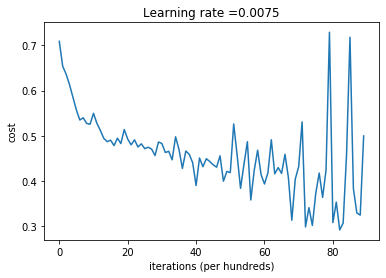

In [21]:
parameters = L_layer_model(train_x, train_y, layers_dims,learning_rate = 0.0075, num_iterations = 9000)

In [22]:
def predict(parameters,X):
    AL,caches=L_model_forward(X,parameters)
    Y_prediction=np.round(AL)
    return Y_prediction

In [23]:
Y_train_prediction=predict(parameters,train_x)
Y_test_prediction=predict(parameters,test_x)
print("Train accuracy : {}%".format(100-np.mean(np.abs(Y_train_prediction-train_y))*100))
print("Test accuracy : {}%".format(100-np.mean(np.abs(Y_test_prediction-test_y))*100))

Train accuracy : 86.1244019138756%
Test accuracy : 76.0%
